In [108]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.metrics import f1_score, recall_score, precision_score

# Building the data set
We want to create a data set of transactions, and whether they are fraudulent or not. In the absence of a positively identified set of non-fraudulent transactions, we will make the next-best assumption that those transactions in the data set that were completed and have not yet been flagged as fraudulent are legitimate.

In [174]:
conn = sqlite3.connect('/Users/tlowe/revolut/revolut.db')
def power(base,exp):
    return int(base)**int(exp)
conn.create_function("power",2,power)
sqlite3.enable_callback_tracebacks(True)

df = pd.read_sql_query(
'''select fraudsters.user_id is not null as                                    is_fraud,
        users.id as user_id,
       transactions.amount * fx.rate / power(10, exponent) usd_amount,
       transactions.CURRENCY,
       transactions.MERCHANT_CATEGORY,
       transactions.MERCHANT_COUNTRY,
       transactions.SOURCE,
       transactions.TYPE,
       transactions.ENTRY_METHOD,
       users.KYC,
       users.FAILED_SIGN_IN_ATTEMPTS,
       users.BIRTH_YEAR,
       users.COUNTRY,
       users.STATE                                                          user_state,
       users.HAS_EMAIL,
       julianday(transactions.CREATED_DATE) - julianday(users.created_date) days_since_user_created
from transactions
  jOIN fx_rates fx
            ON (fx.ccy = transactions.currency
              AND fx.base_ccy = 'USD')
       JOIN currency_details cd
            ON cd.currency = transactions.currency
       left join
     fraudsters using (user_id)
       join users on transactions.user_id = users.id
where (transactions.state = 'COMPLETED' and users.STATE != 'LOCKED')
   or is_fraud''',
conn)

Add some copy and pasted functions to show the performance of a binary classifier - source https://www.accelebrate.com/blog/fraud-detection-using-python

In [111]:
def PrintStats(cmat, y_test, pred):
    # separate out the confusion matrix components
    tpos = cmat[0][0]
    fneg = cmat[1][1]
    fpos = cmat[0][1]
    tneg = cmat[1][0]
    # calculate F!, Recall scores
    f1Score = round(f1_score(y_test, pred), 2)
    recallScore = round(recall_score(y_test, pred), 2)
    precisionScore = round(precision_score(y_test, pred), 2)
    # calculate and display metrics
    print(cmat)
    print( 'Accuracy: '+ str(np.round(100*float(tpos+fneg)/float(tpos+fneg + fpos + tneg),2))+'%')
    print( 'Cohen Kappa: '+ str(np.round(cohen_kappa_score(y_test, pred),3)))
    print("Precision for Model : {precision_score}".format(precision_score = precisionScore))
    print("Recall for Model : {recall_score}".format(recall_score = recallScore))
    print("F1 Score for Model : {f1_score}".format(f1_score = f1Score))
def RunModel(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train.values.ravel())
    pred = model.predict(X_test)
    matrix = confusion_matrix(y_test, pred)
    return matrix, pred

# Building the model
Here we define the features that will go into the model and pre-process them. We need to encode our categorical variables into dummy/one-hot columns as logistic regression doesn't work with non-numerical features.

In [182]:

column_types = {"target":"is_fraud",
               "numerical":["usd_amount","BIRTH_YEAR","FAILED_SIGN_IN_ATTEMPTS","days_since_user_created"],
               "boolean":["HAS_EMAIL"],
               "categorical":["user_state","MERCHANT_CATEGORY","TYPE","SOURCE","CURRENCY" ,"ENTRY_METHOD", 'KYC']}
y = df.pop('is_fraud')
user_ids = df.pop('user_id')
#one-hot encode categorical variables

categorical_variables = column_types["categorical"]
one_hot_X = pd.get_dummies(df[categorical_variables])

X = df[column_types['numerical']].join(df[column_types['boolean']]).join(one_hot_X)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
np.random.seed(13)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, test_size=0.7, random_state=1)
lr_all_vars = LogisticRegression()
cmat, pred = RunModel(lr_all_vars, X_train, y_train, X_test, y_test)
PrintStats(cmat, y_test, pred)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[384210      0]
 [     0  10067]]
Accuracy: 100.0%
Cohen Kappa: 1.0
Precision for Model : 1.0
Recall for Model : 1.0
F1 Score for Model : 1.0


# Congratulations, you've solved fraud!
...it's surprising to note that we have reached 100% accuracy. Something is up! Let's take a look at the coefficients.

In [191]:
coeffs = pd.DataFrame(list(zip(lr_all_vars.coef_[0],X_train.columns)))
coeffs.rename(columns={0:"weight", 1:"feature"}).sort_values('weight', ascending=False)

,weight,feature
6,5.305171,user_state_LOCKED
148,0.809013,CURRENCY_GBP
136,0.608490,SOURCE_MINOS
170,0.569920,ENTRY_METHOD_manu
176,0.488240,KYC_PENDING
123,0.260451,TYPE_ATM
124,0.178375,TYPE_BANK_TRANSFER
18,0.171985,MERCHANT_CATEGORY_atm
127,0.084071,TYPE_TOPUP
173,0.080665,KYC_FAILED


Features with a positive weight are positively associated with fraud, and categorical variables can be compared by weight (we didn't standardize numerical features so these coefficients are not on the same scale).

Our number  most informative feature: Users that have been identified as fraudulent have had their accounts locked. Makes sense! What if we take the user state feature out?

In [192]:

column_types = {"target":"is_fraud",
               "numerical":["usd_amount","BIRTH_YEAR","FAILED_SIGN_IN_ATTEMPTS","days_since_user_created"],
               "boolean":["HAS_EMAIL"],
               "categorical":["TYPE","SOURCE","ENTRY_METHOD","KYC","CURRENCY"]}

#one-hot encode categorical variables
from sklearn import preprocessing
categorical_variables = column_types["categorical"]
one_hot_X = pd.get_dummies(df[categorical_variables])

X = df[column_types['numerical']].join(df[column_types['boolean']]).join(one_hot_X)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
np.random.seed(13)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, test_size=0.7, random_state=1)
lr_limited = LogisticRegression()
cmat, pred = RunModel(lr_limited, X_train, y_train, X_test, y_test)
PrintStats(cmat, y_test, pred)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[384002    208]
 [  8484   1583]]
Accuracy: 97.8%
Cohen Kappa: 0.261
Precision for Model : 0.88
Recall for Model : 0.16
F1 Score for Model : 0.27


Using some copy/paste code to evaluate the model's precision/recall tradeoffs in greater depth - source https://morioh.com/p/2298e2750226/how-to-assess-a-binary-logistic-regressor-with-scikit-learn

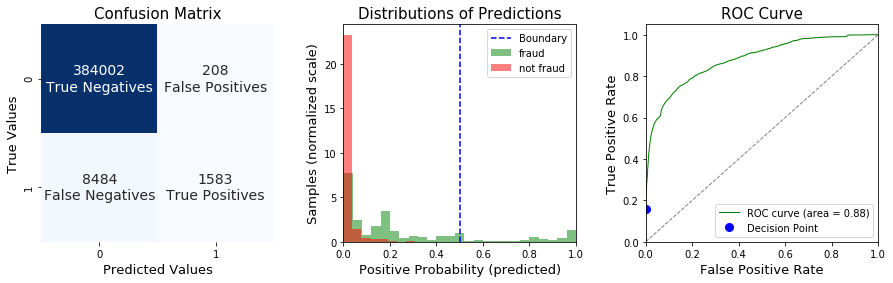

Precision: 0.88 | Recall: 0.16 | F1 Score: 0.27 | 


0.26699274751222807

In [177]:
def evalBinaryClassifier(model, x, y, labels=['Positives','Negatives']):
    '''
    Visualize the performance of  a Logistic Regression Binary Classifier.
    
    Displays a labelled Confusion Matrix, distributions of the predicted
    probabilities for both classes, the ROC curve, and F1 score of a fitted
    Binary Logistic Classifier. Author: gregcondit.com/articles/logr-charts
    
    Parameters
    ----------
    model : fitted scikit-learn model with predict_proba & predict methods
        and classes_ attribute. Typically LogisticRegression or 
        LogisticRegressionCV
    
    x : {array-like, sparse matrix}, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples
        in the data to be tested, and n_features is the number of features
    
    y : array-like, shape (n_samples,)
        Target vector relative to x.
    
    labels: list, optional
        list of text labels for the two classes, with the positive label first
        
    Displays
    ----------
    3 Subplots
    
    Returns
    ----------
    F1: float
    '''
    #model predicts probabilities of positive class
    p = model.predict_proba(x)
    if len(model.classes_)!=2:
        raise ValueError('A binary class problem is required')
    if model.classes_[1] == 1:
        pos_p = p[:,1]
    elif model.classes_[0] == 1:
        pos_p = p[:,0]
    
    #FIGURE
    plt.figure(figsize=[15,4])
    
    #1 -- Confusion matrix
    cm = confusion_matrix(y,model.predict(x))
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
              'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)
      
    #2 -- Distributions of Predicted Probabilities of both classes
    df = pd.DataFrame({'probPos':pos_p, 'target': y})
    plt.subplot(132)
    plt.hist(df[df.target==1].probPos, density=True, bins=25,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(df[df.target==0].probPos, density=True, bins=25,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(.5, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distributions of Predictions', size=15)
    plt.xlabel('Positive Probability (predicted)', size=13)
    plt.ylabel('Samples (normalized scale)', size=13)
    plt.legend(loc="upper right")
    
    #3 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y,p[:,1])
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='green',
             lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    #plot current decision point:
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()
    #Print and Return the F1 score
    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    printout = (
        f'Precision: {round(precision,2)} | '
        f'Recall: {round(recall,2)} | '
        f'F1 Score: {round(F1,2)} | '
    )
    print(printout)
    return F1

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix, auc
from sklearn import linear_model
evalBinaryClassifier(lr_limited, X_test, y_test, labels=["fraud", "not fraud"])

Though this would be an ineffective model to use in production (only 16% of fraudulent transactions would be flagged), it's actually pretty useful for our purposes because precision is high at 88%. This means that 88% of the transactions the model identified as fraudulent were actually fraudulent. As our task is to identify 5 fraudulent users, this model is useful. Let's find those users with the highest proportion then volume of predicted fraudulent transactions, who were not flagged as fraudulent in the initial data set.

In [179]:
fraud_predictions = lr_limited.predict(X)

predictor_df = X.copy()
predictor_df['predicted_fraud'] = fraud_predictions
predictor_df['user_id'] = user_ids
predictor_df['is_fraud'] = y
not_known_as_fraud = predictor_df[(predictor_df['is_fraud']==0)]
user_fraud_predicted = not_known_as_fraud.groupby(by='user_id').agg({"predicted_fraud":"sum", "user_id":"count"}).rename({"user_id":"total_transactions"})
user_fraud_predicted['pct_predicted'] = user_fraud_predicted['predicted_fraud']/user_fraud_predicted['user_id']
predicted_fraudsters = user_fraud_predicted.sort_values(['pct_predicted','user_id'], ascending=False).head(5)
predicted_fraudsters.user_id

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  # Remove the CWD from sys.path while we load stuff.


user_id
51de0c9c-1b42-4f7a-b5cc-5a99b323775b    3
689f0b71-2ed2-48c9-bbe0-a417cb733b09    3
621a3884-5283-49f0-8a19-6dd825e9de14    2
712bc523-6ab5-4a29-8465-61bd7573b4d6    2
85f38f91-0bcf-415b-b95a-d12482e9a2bb    2
Name: user_id, dtype: int64

# Future Improvements

* This model evaluates each transaction individually - in doing so we lose the bigger picture about overall user behavior. By aggregating transaction information to the user level we could take into account user transaction patterns which are likely informative.
* The assumption that the transactions not yet flagged as fraud are legitimate harms the validity of the model. Finding a data set of confirmed valid transactions would make the results more believable.
* It would be worthwhile trying other binary classification methods - Random Forest, k-Nearest Neighbors and Neural Network BC.